# DEEP LEARNING - PRACTICUM 03

- Diego Roca Rodríguez
- Roi Santos Ríos

Wasserstein Generative Adversarial Networks, with Gradient Penalty (WGAN-GP)

In [87]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.linalg import sqrtm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt

from utils import display, sample_batch, display_one

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128


EPOCHS = 1
STEPS_PER_EPOCH = 10


LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "./data/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
# Repeat the dataset
train_data = train_data.repeat()

Found 202599 files belonging to 1 classes.


2023-05-10 12:49:31.361209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 12:49:31.361923: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Load the pre-trained Inception v3 model
inception_v3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [5]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    
    return img


train = train_data.map(lambda x: preprocess(x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [116]:
# Show some faces from the training set
train_sample = sample_batch(train)+

(64, 32, 32, 3)


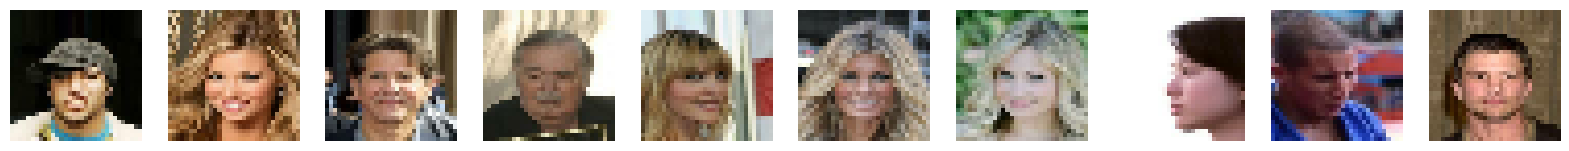

In [7]:
display(train_sample, cmap=None)

## 2. Build the WGAN-GP <a name="build"></a>

In [8]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_95 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_96 (Conv2D)          (None, 4, 4, 256)         524544

In [9]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_94 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        5242

In [10]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [11]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [12]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [13]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

In [15]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

10/10 [==============================] - ETA: 0s - c_loss: -6.6702 - c_wass_loss: -10.1938 - c_gp: 0.3524 - g_loss: -1.5855 - c_acc: 99.0625 - g_acc: 22.3438
Saved to ./output/generated_img_000.png


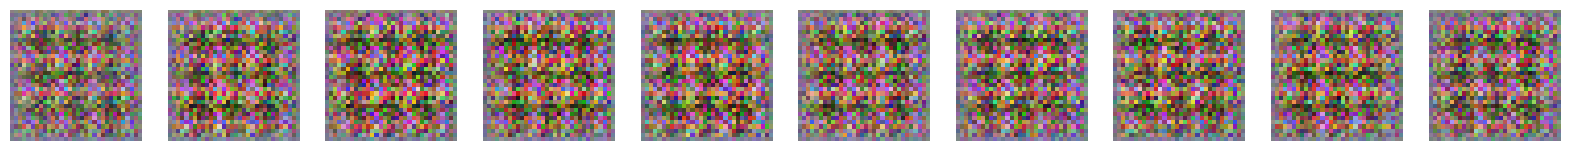

10/10 [==============================] - 11s 747ms/step - c_loss: -6.6702 - c_wass_loss: -10.1938 - c_gp: 0.3524 - g_loss: -1.5855 - c_acc: 99.1477 - g_acc: 20.3125


In [16]:
loss_history = LossHistory()

wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM), loss_history],
)

In [17]:
"""
# original
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)
"""

'\n# original\nwgangp.fit(\n    train,\n    epochs=EPOCHS,\n    steps_per_epoch=2,\n    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],\n)\n'

In [17]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


# 4. Results

### Fréchet Inception Distance (FID)

In [18]:
# Define a function to calculate FID
def calculate_fid(real_features, generated_features):
    # Calculate the mean and covariance of the real and generated features
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    cov_generated = np.cov(generated_features, rowvar=False)

    # Calculate the squared difference between the means
    diff = mu_real - mu_generated
    diff_squared = np.dot(diff, diff)

    # Calculate the square root of the product of the covariances
    cov_sqrt = sqrtm(cov_real.dot(cov_generated))

    # Calculate the FID
    fid = diff_squared + np.trace(cov_real + cov_generated - 2 * cov_sqrt)

    return fid

def preprocess_inception(image):
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

## Generate images

1/1 [==============================] - 0s 20ms/step
(10, 2048)


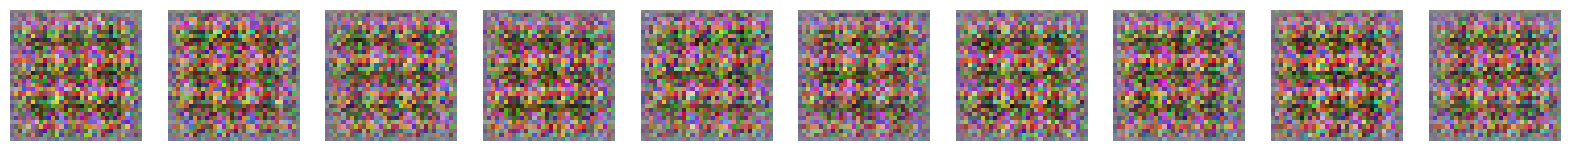

In [101]:
z_sample = np.random.normal(size=(10, Z_DIM))

# Generate a batch of images using your model
generated_images = wgangp.generator.predict(z_sample)

# Preprocess the images
preprocessed_images = np.array([preprocess_inception(image) for image in generated_images])

# Extract features from the images
generated_features = inception_v3(preprocessed_images)
generated_features = tf.keras.backend.eval(generated_features)

print(generated_features.shape)

display(generated_images, cmap=None)

## Load real images

In [115]:
# Load 10 real images from the training dataset
#train_sample = np.array([image for image in np.squeeze(train.take(10), axis=0)])

for i in range(10):
    sample = train.take(1).get_single_element()
    np.squeeze(sample, axis=0)
    print(sample.shape)
    np.append(train_sample, sample)
# Remove the batch dimension


# Preprocess the images
preprocessed_images = np.array([preprocess_inception(image) for image in train_sample])

# Extract features from the images
real_features = inception_v3(preprocessed_images)
real_features = tf.keras.backend.eval(real_features)

print(real_features.shape)
# Calculate the FID
fid = calculate_fid(real_features, generated_features)

print("FID:", fid)
#display(preprocessed_image, cmap=None)

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [ ]:
def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)